## Sales Prediction for 1C Company

Name : Karishma Saikia

### BACKGROUND

This is a time-series dataset which contains daily sales data of the largest Russian software firms - 1C Company.

**Column list:**

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

### PROBLEM STATEMENT

Predict total sales for next 3-4 months

### DATA EXPLORATION and CLEANING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from datetime import datetime, date
plt.rcParams.update({'font.size': 16})
from statsmodels.tsa.stattools import adfuller
import requests
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display, Markdown, Latex
from sklearn.metrics import mean_absolute_error
import itertools

Let us read the data

In [2]:
data=pd.read_csv("sales_train.csv")
data.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


Check if there are any NULL values and check the data types of the variables

In [3]:
data.count()

date              2935849
date_block_num    2935849
shop_id           2935849
item_id           2935849
item_price        2935849
item_cnt_day      2935849
dtype: int64

In [4]:
data.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

Let us see the unique values for shop ID and and item ID

In [5]:
data.groupby(data.shop_id).count().sort_values(['date'], ascending=False).head(2)

,date,date_block_num,item_id,item_price,item_cnt_day
shop_id,,,,,
31,235636,235636,235636,235636,235636
25,186104,186104,186104,186104,186104


In [6]:
data.groupby(data.item_id).count().sort_values(['date'], ascending=False).head(2)

,date,date_block_num,shop_id,item_price,item_cnt_day
item_id,,,,,
20949,31340,31340,31340,31340,31340
5822,9408,9408,9408,9408,9408


Since, *item_cnt_day* can only be an integer, let us change the values to integer type by ceiling it into next higher level.

In [7]:
# data['item_cnt_day']=np.ceil(data.item_cnt_day)
try:
    data.item_cnt_day=data.item_cnt_day.astype(int)
except:
    print("Already done")

In [8]:
data_31=data.copy()

Let us see the graph representing  number of products sold in 33 months.

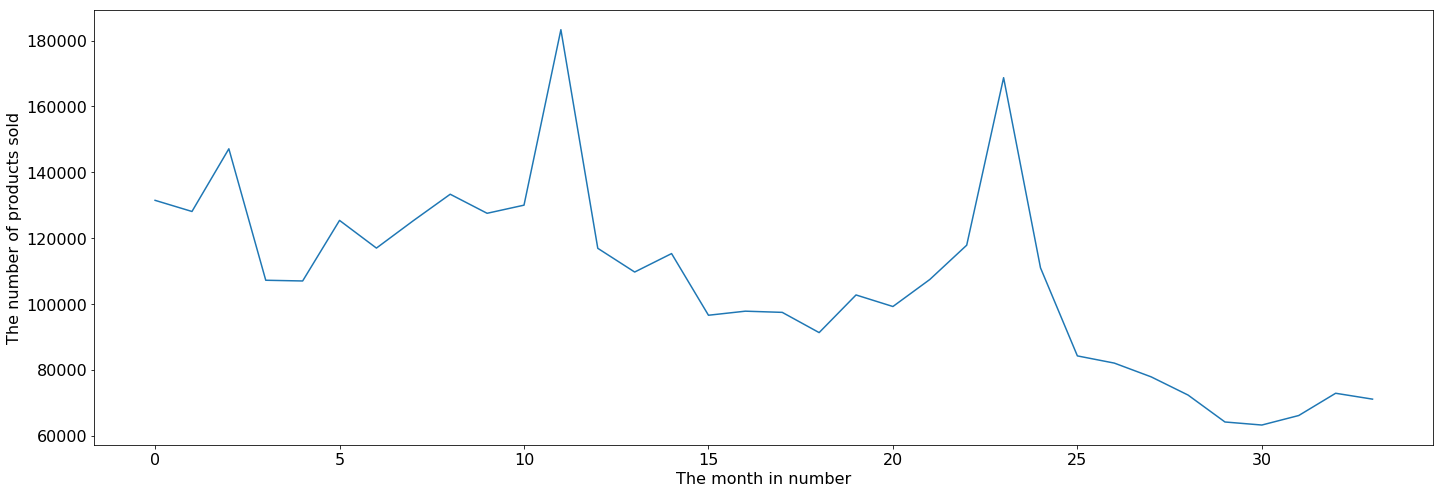

In [9]:
plt.rcParams.update({'font.size': 16})
y=data_31.groupby(['date_block_num']).sum()['item_cnt_day']
grouped_df=pd.DataFrame({"Total products": y})
grouped_df=grouped_df.reset_index(level=['date_block_num'])
plt.figure(figsize=(24,8))


sns.lineplot(x=grouped_df['date_block_num'],y=grouped_df['Total products'])
plt.ylabel("The number of products sold")
plt.xlabel("The month in number")
plt.show()

We can see that there is a decreasing trend. To comment on the seasonality, we need to check with respect to the time series. Let us change the Date column into TS object.

In [10]:
data_31['Month-Year'] = data_31.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y-%m'))

Let us change the column names for simplicity

In [11]:
data_31['Total_products_sold']=data_31['item_cnt_day']

In [12]:
data_31.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Month-Year,Total_products_sold
0,02.01.2013,0,59,22154,999.0,1,2013-01,1
1,03.01.2013,0,25,2552,899.0,1,2013-01,1


We will keep only the 'Month-Year' and 'Total products sold' columns for analysis

In [13]:
ts=data_31.groupby(['Month-Year']).sum()['Total_products_sold']
ts_df=pd.DataFrame(ts)

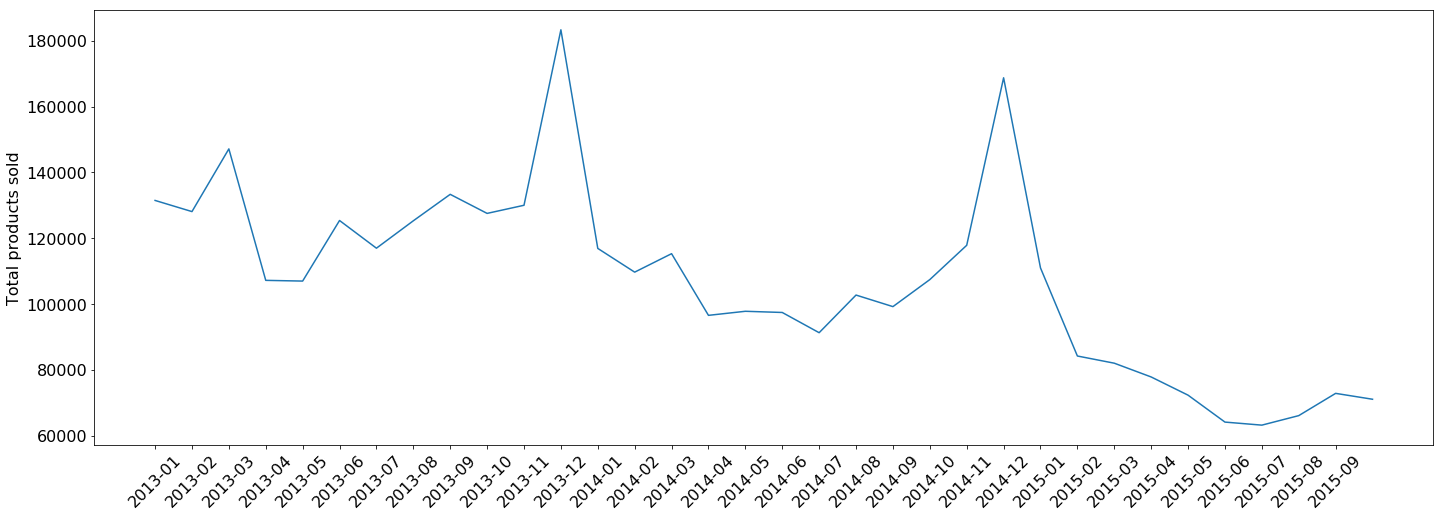

In [14]:
plt.figure(figsize=(24,8))
tick_locations=[value for value in np.arange(33)]
plt.xticks(tick_locations, rotation=45)
plt.ylabel("Total products sold")
plt.plot(ts)

### STATIONARIZE TIME SERIES

### Dicker Fuller Test
It is clearly evident that there is an overall decreasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. So, more formally, we can check stationarity using the Dicker Fuller Test.

This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for different confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary

In [15]:

def test_stationarity(timeseries):
    
    #Determing rolling statistics
#     ts_log.rolling(12).mean()
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(24,8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    tick_locations=[value for value in np.arange(33)]
    plt.xticks(tick_locations, rotation=45)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

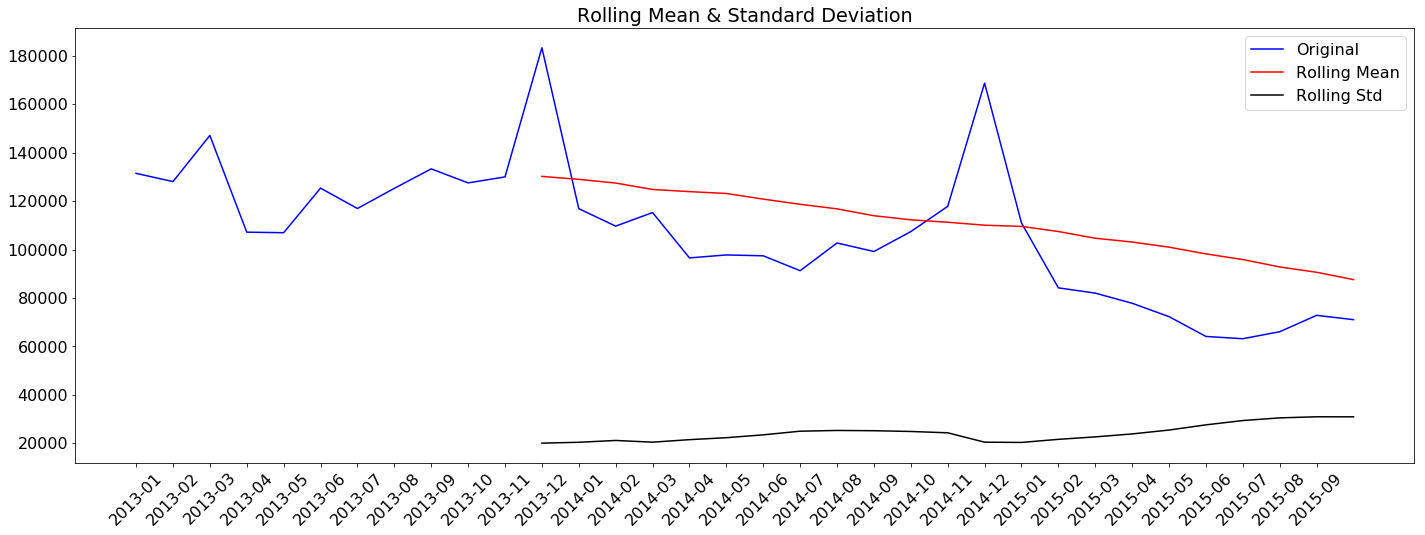

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [16]:
plt.rcParams.update({'font.size': 16})
test_stationarity(ts)


Since p >0.05 and test statistic > critical values, we accept Null hypothesis which states that it is non stationary. We need to change to stationary.

There are many techniques with which we can stationarize a model. Let us first proceed with moving average. Although moving average do not perform well when there is seasonality. Let see

**Moving average**

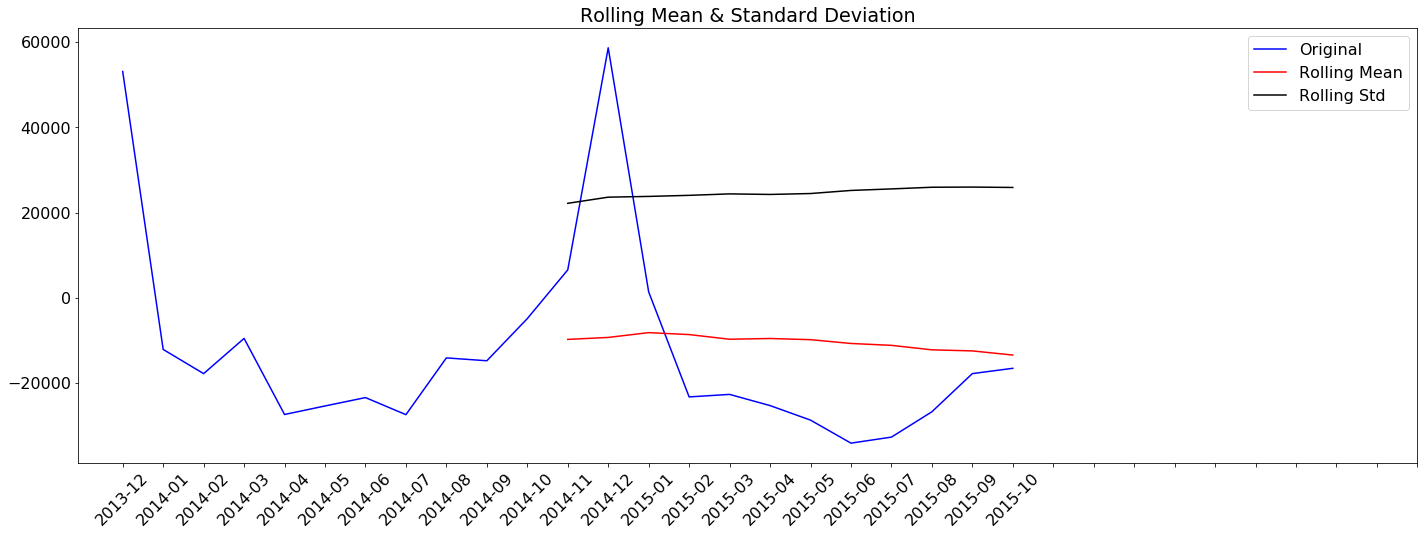

Results of Dickey-Fuller Test:
Test Statistic                 -4.010631
p-value                         0.001356
#Lags Used                      0.000000
Number of Observations Used    22.000000
Critical Value (1%)            -3.769733
Critical Value (5%)            -3.005426
Critical Value (10%)           -2.642501
dtype: float64


In [17]:
plt.rcParams.update({'font.size': 16})

moving_avg = ts.rolling(12).mean()
ts_movingavg_diff=ts-moving_avg
ts_movingavg_diff.dropna(inplace=True)
test_stationarity(ts_movingavg_diff)

From above test we can see that, the ts is stationary now. Let us also check for some other methods for better results.

**De trend by differencing**

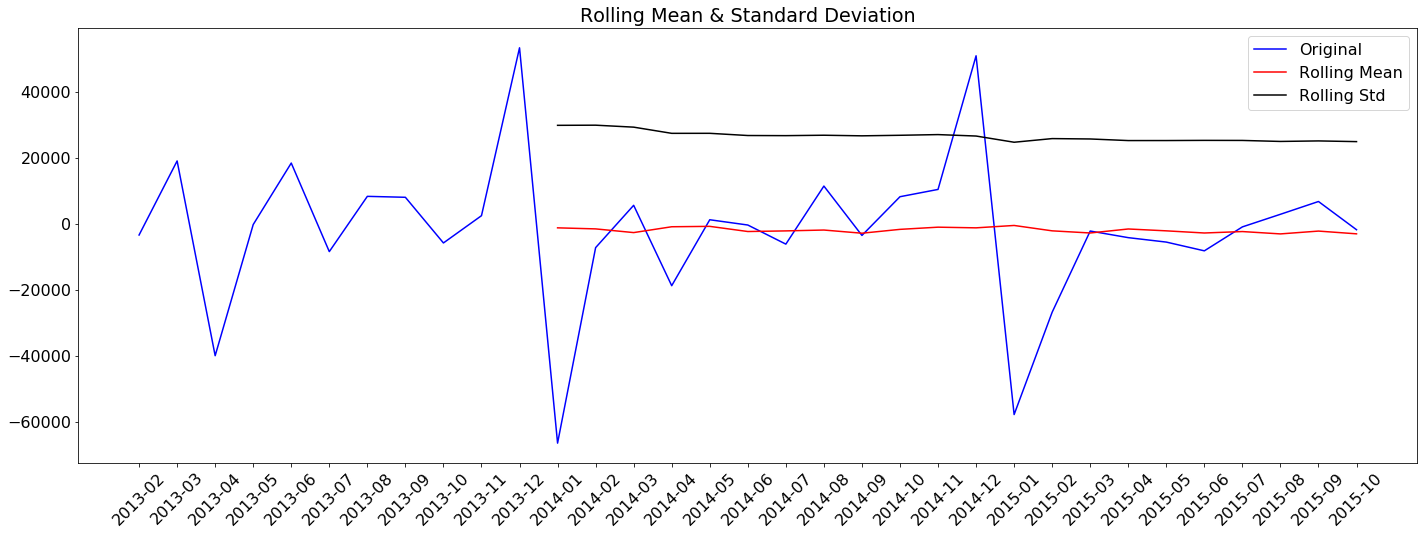

Results of Dickey-Fuller Test:
Test Statistic                -1.363622e+01
p-value                        1.686395e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64


In [18]:
plt.rcParams.update({'font.size': 16})
ts_diff=ts-ts.shift()
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

The Dickey-Fuller test statistic and p value are significantly lower than the 1% critical value and  0.05 respectively, so we can say that TS is close to stationary with 99% confidence.

**Removing seasonality by differencing**

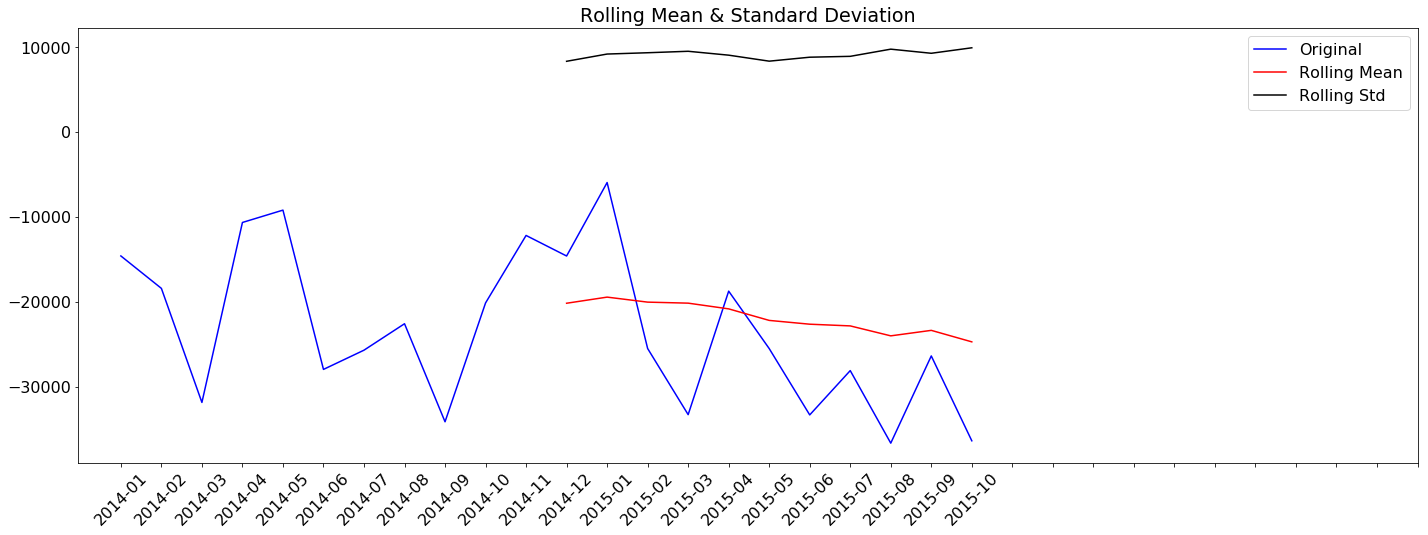

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [19]:
ts_seasonal_diff=ts-ts.shift(12)
ts_seasonal_diff.dropna(inplace=True)
test_stationarity(ts_seasonal_diff)

Can still see a trend in the graph, so cannot accept it. Also, test statistic is not good.

**De trend by log transform**

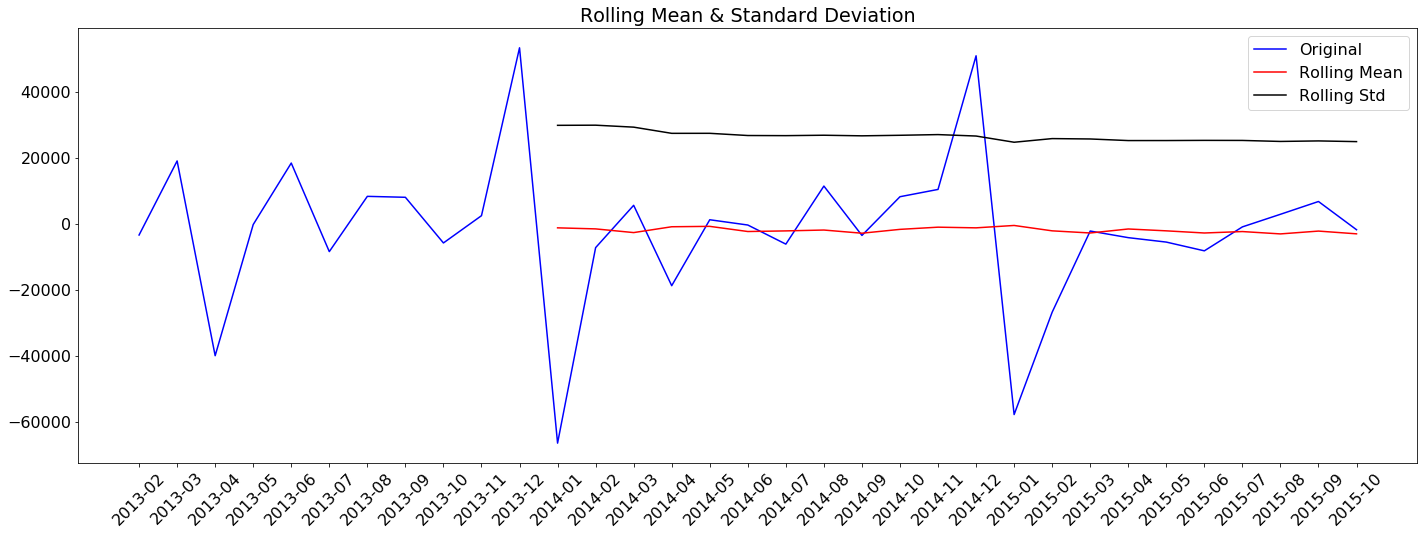

Results of Dickey-Fuller Test:
Test Statistic                -1.363622e+01
p-value                        1.686395e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64


In [20]:
ts_log=ts-ts.shift()
ts_log.dropna(inplace=True)
test_stationarity(ts_log)

p>0.05, so it is not stationary. <br>

From all the above options, we will move ahead with de trending with differencing which gave us the best best results so far

In [21]:
ts_original=ts.copy()

### ARIMA MODEL

Now let us fit a model but at this point we arent sure of the model parameters which is defined below-
- Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. 
- Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. 
- Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference to stationarize the series.

PACF and ACF will help us determine p and q values.<br>

let us plot for both the time series - stationarized and non stationarized time series



C:\Users\karis\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


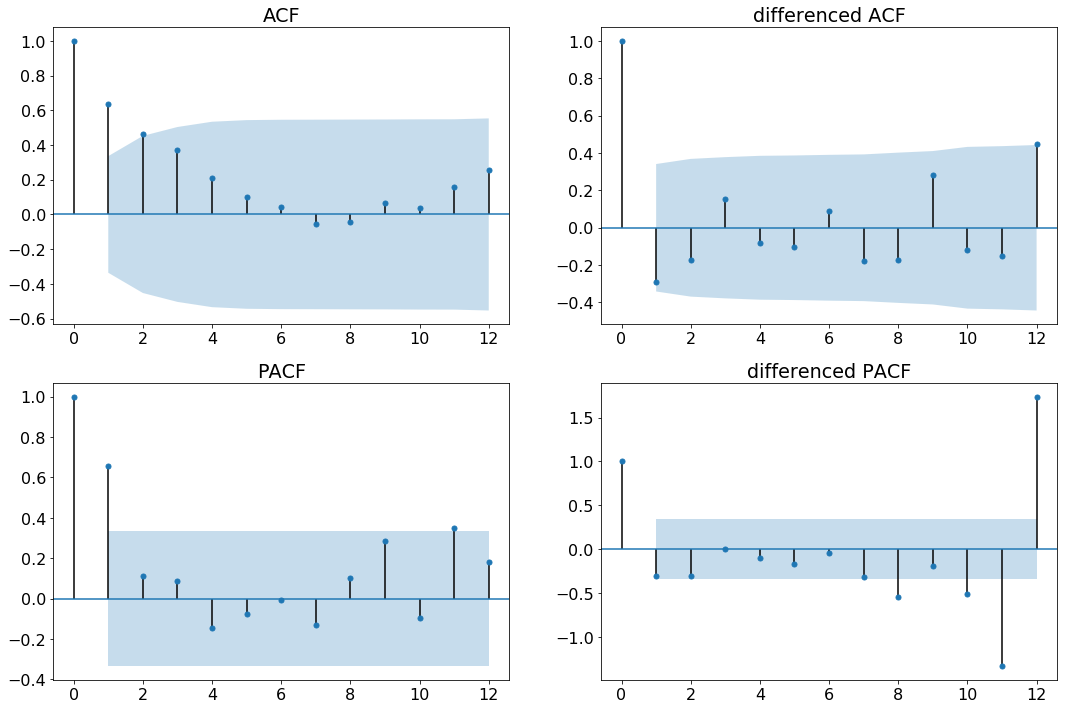

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(18,12))
ax[0, 0] = plot_acf(ts, ax=ax[0, 0], lags=12, title="ACF")
ax[1, 0] = plot_pacf(ts, ax=ax[1, 0], lags=12, title="PACF")

ax[0, 1] = plot_acf(ts_diff , ax=ax[0, 1], lags=12, title="differenced ACF")
ax[1, 1] = plot_pacf(ts_diff, ax=ax[1, 1], lags=12, title="differenced PACF")

We can see that, p=q=1 approximately. Let us again verify with a different type of plot to derive p and q values. <br>
It is said that most of the sample autocorrelation coefficients lie within the limits (-1.96/sqrt(N)) and (+1.96/sqrt(N)) where N is the number of observations

Now, lets make 4 different ARIMA models with considering individual as well as combined effects <br>
We will take the non stationarized time series with d=1 (as proved earlier)

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
model = ARIMA(ts.dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

model = ARIMA(ts.dropna(), (1, 1, 0))
res_110 = model.fit()
print(res_110.summary())

model = ARIMA(ts.dropna(), (0, 1, 1))
res_011 = model.fit()
print(res_011.summary())

model = ARIMA(ts.dropna(), (1, 1, 1))
res_111 = model.fit()
print(res_111.summary())

                               ARIMA Model Results                               
Dep. Variable:     D.Total_products_sold   No. Observations:                   33
Model:                    ARIMA(0, 1, 0)   Log Likelihood                -378.124
Method:                              css   S.D. of innovations          22910.644
Date:                   Sat, 22 Jun 2019   AIC                            760.247
Time:                           23:59:01   BIC                            763.241
Sample:                       02-01-2013   HQIC                           761.255
                            - 10-01-2015                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1831.0000   3988.231     -0.459      0.649   -9647.790    5985.790
                               ARIMA Model Results                               
Dep. Variable:     D.Tota

In [25]:
x=round(res_010.aic,3)
y=round(res_011.aic,3)
z=round(res_110.aic,3)
v=round(res_111.aic,3)

In [26]:
Markdown("""
| ARIMA MODEL PARAMETERS | AIC |
| ------ | ----- | 
| 010 | {x} |
|011 | {y} |
| 110 | {z} |
| 111 | {v} |
""".format(x=x,y=y,z=z,v=v))


| ARIMA MODEL PARAMETERS | AIC |
| ------ | ----- | 
| 010 | 760.247 |
|011 | 757.508 |
| 110 | 759.445 |
| 111 | 755.147 |


It can be seen that ARIMA(1,1,1) performs best as expected.

In [27]:
# ts_df=ts_df.reset_index()
ts_df=pd.DataFrame(ts)
# ts_df

In [28]:
model = ARIMA(ts, (1, 1, 1))
res_all = model.fit()

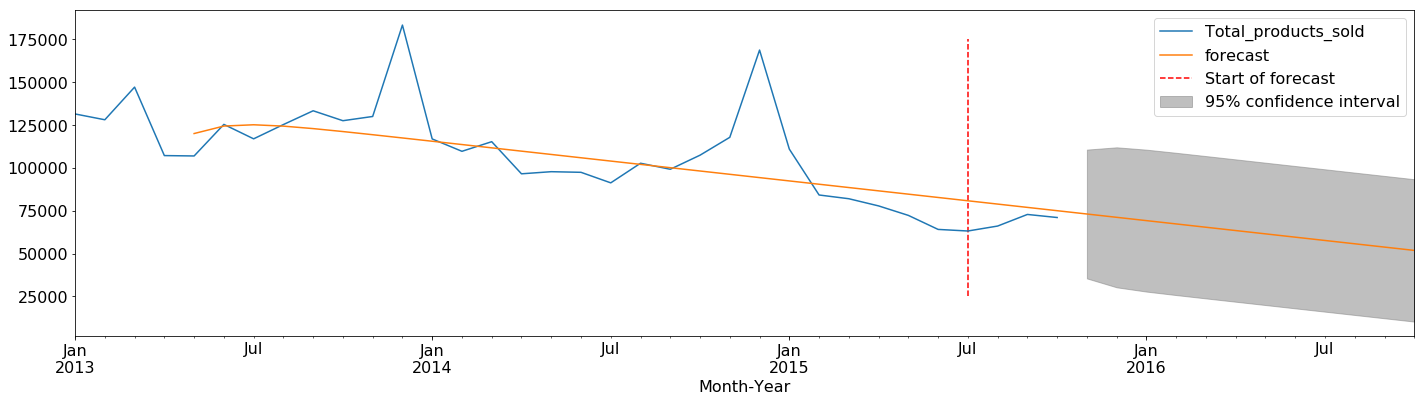

In [29]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(24, 6));

ts_df.index = pd.to_datetime(ts_df.index, format="%Y-%m");
ts_df.Total_products_sold.plot(ax=ax);

ax.vlines('2015-07',25000,175000, linestyle='--', color='r', label='Start of forecast');
res_all.plot_predict(start ='2013-05', end = '2016-10', dynamic = True, plot_insample=False, ax=ax);

In [30]:
res_all.plot_predict(start ='2013-05', end = '2015-10', dynamic = True, plot_insample=False, ax=ax);

Clearly the seasonal variations are not considered in the model.

Let us search optimal parameters for the ARIMA model and compare it with the one above

In [31]:
import statsmodels.tsa.api as smt
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        for k in rng:
            try:
                tmp_mdl = ARIMA(ts, order=(i, j,k)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, j,k)
                    best_mdl = tmp_mdl
            except: continue
             
                

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 741.40330 | order: (1, 2, 2)


**Lets us fit the ARIMA model**<br>
Converted the values to logarithmic values

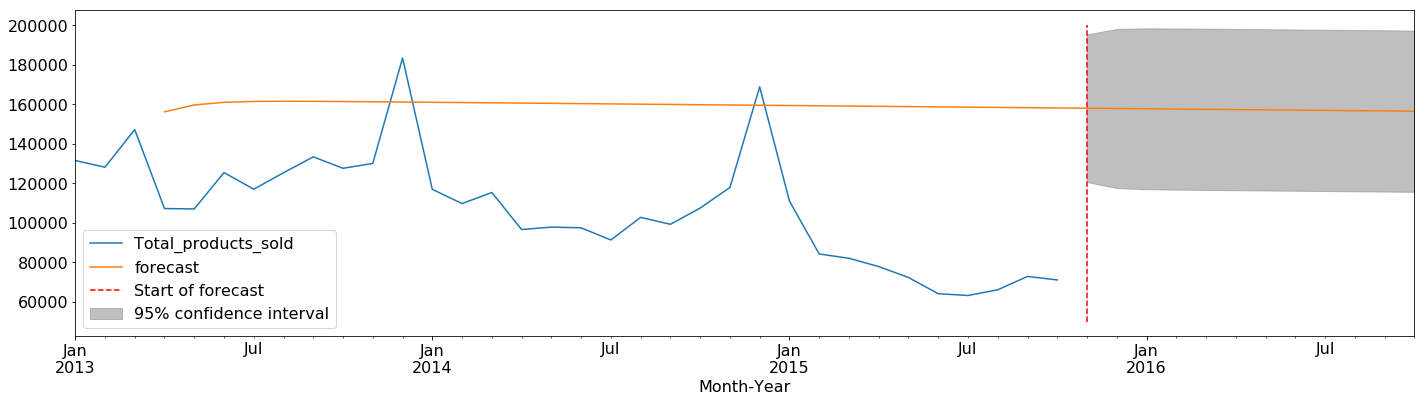

In [32]:
model = ARIMA(ts, (1, 2, 2))
res_opt = model.fit()

fig, ax = plt.subplots(figsize=(24, 6));

ts_df.index = pd.to_datetime(ts_df.index, format="%Y-%m");
ts_df.Total_products_sold.dropna().plot(ax=ax)
ax.vlines('2015-11',50000,200000, linestyle='--', color='r', label='Start of forecast');
res_opt.plot_predict(start = '2013-04', end = '2016-10', dynamic = True, plot_insample=False, ax=ax);

**Before rejecting the above models,let us check the residual mean for both the models**

In [33]:
print(f"The mean for ARIMA(1,1,1) is {np.mean(res_all.resid)}")
print(f"The mean for ARIMA(1,2,2) is {np.mean(res_opt.resid)}")

The mean for ARIMA(1,1,1) is 1270.1563386198604
The mean for ARIMA(1,2,2) is 693.1216871162007


**Definitely the models are not performing well with ARIMA due to yearly seasonal variations**<br>
Let us move ahead with Seasonal ARIMA after finding the optimal parameters

The code chunk below iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.

In [34]:
best_aic=np.inf
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            tmp_aic=results.aic
            if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = param
                    best_seasonal = param_seasonal

#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
        except:
            continue
            
print('aic: {:6.5f} | order: {} | seasonal_order {}'.format(best_aic, best_order, best_seasonal))

aic: 171.01934 | order: (1, 1, 1) | seasonal_order (1, 1, 0, 12)


**Fitting the seasonal ARIMA with optimal parameters**

In [35]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0484      2.962     -0.354      0.723      -6.854       4.757
ma.L1         -0.3043      1.466     -0.208      0.836      -3.177       2.569
ar.S.L12       0.4111      1.763      0.233      0.816      -3.045       3.867
sigma2      9.765e+07   6.77e-09   1.44e+16      0.000    9.76e+07    9.76e+07


**Our data is till Oct-2015. Predicting till May 2016**

In [36]:
pred = results.get_prediction(start=pd.to_datetime('2013-01-01'), end=pd.to_datetime('2016-05-01'), dynamic=False)
pred_ci = pred.conf_int()

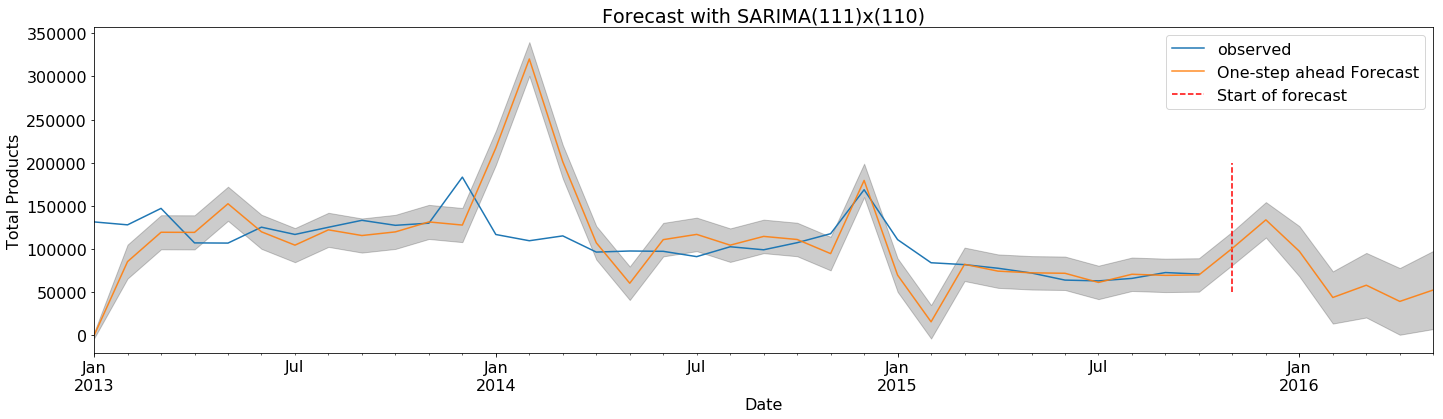

In [37]:
# plt.figure(figsize=(24,8))
fig, ax = plt.subplots(figsize=(24, 6));
ax=ts_df['Total_products_sold'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

ax.vlines('2015-11-01',50000,200000, linestyle='--', color='r', label='Start of forecast');
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Products')
plt.legend()
plt.title("Forecast with SARIMA(111)x(110)")
plt.show()



**It is always better to quantify the accuracy of our forecasts. We will use mean of residuals and the MSE (Mean Squared Error), which summarizes the average error**

In [38]:
y_predict = results.get_prediction(start=pd.to_datetime('2013-01-01'), end=pd.to_datetime('2015-10-01'), dynamic=False)

y_forecasted = y_predict.predicted_mean
y_truth = ts_df.Total_products_sold

residual_mean=np.mean(y_forecasted - y_truth)

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The mean of residuals is {}'.format(round(residual_mean, 2)))

The Mean Squared Error of our forecasts is 2857807429.92
The mean of residuals is 2009.22


**Clearly with such statistical measures, we cannot accept this**

### FBPROPHET

PROPHET is recently open-sourced by Facebook research

It implements a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well

Another neat functionality is that it follows the typical sklearn syntax.

At its core, it has four main components:

- A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
- A yearly seasonal component modeled using Fourier series.
- A weekly seasonal component using dummy variables.
- A user-provided list of important holidays.

From our initial analysis, we can say that our model is additive as the trend the trend in seasonal variations were almost constant.

In [39]:
ts_df_prophet=ts_df.reset_index(level="Month-Year")
# ts_df_prophet
ts_df_prophet.columns=['ds','y']
ts_df_prophet.head(2)

,ds,y
0,2013-01-01,131479
1,2013-02-01,128090


In [40]:
from fbprophet import Prophet
#prophet reqiures a pandas df

model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts_df_prophet) 

# predict for 10 months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 10, freq = 'MS') 

# now lets make the forecasts
forecast_prophet = model.predict(future)

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
forecast_prophet.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,141678.041846,128880.866464,135193.369443,141678.041846,141678.041846,-9566.680613,-9566.680613,-9566.680613,-9566.680613,-9566.680613,-9566.680613,0.0,0.0,0.0,132111.361232
1,2013-02-01,139958.210510,127961.083703,134087.135179,139958.210510,139958.210510,-8929.017472,-8929.017472,-8929.017472,-8929.017472,-8929.017472,-8929.017472,0.0,0.0,0.0,131029.193038


In [42]:
forecast_prophet=forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
# model.plot(forecast)
forecast_prophet.head(2)

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,132111.361232,128880.866464,135193.369443
1,2013-02-01,131029.193038,127961.083703,134087.135179


In [43]:
pred_prophet = np.asarray(forecast_prophet['yhat'])
y_truth = ts_df.Total_products_sold

**Accuracy measures with prophet model**

For calculating the same, we need to filter the predicted values till October 2015

In [44]:
residual_mean=np.mean(pred_prophet[0:34] - y_truth)

# Compute the mean square error
mse = ((pred_prophet[0:34] - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The mean of residuals is {}'.format(round(residual_mean, 2)))

The Mean Squared Error of our forecasts is 5962534.14
The mean of residuals is -0.04


In [45]:
#MAE calculation of all the models
arima_plot=res_all.predict()
print(f"arima: {mean_absolute_error(y_truth[1:34],arima_plot)}")

arima_opt_pred=res_opt.predict()
print(f"arima from optimum : {mean_absolute_error(y_truth[2:34],arima_opt_pred)}")

print(f"sarima : {mean_absolute_error(y_truth,y_forecasted)}")

print(f"fb prophet : {mean_absolute_error(y_truth,pred_prophet[0:34])}")

arima: 109668.6411871047
arima from optimum : 106537.96543711619
sarima : 30388.767122591285
fb prophet : 1980.605877391377


**MSE is reduced compared to previous models and also residual mean is zero**

In [46]:
forecast_prophet2=forecast_prophet.groupby(['ds']).sum()['yhat']

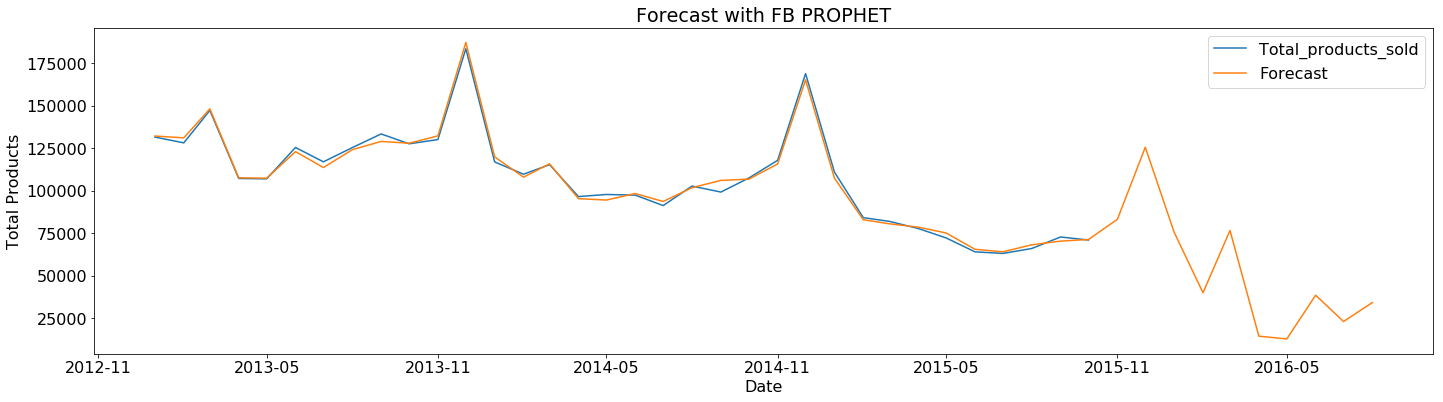

In [47]:
fig, ax = plt.subplots(figsize=(24, 6));
plt.plot(ts_df['Total_products_sold'])
plt.plot(forecast_prophet2,label='Forecast',alpha=2)




ax.set_xlabel('Date')
ax.set_ylabel('Total Products')
plt.legend()
plt.title("Forecast with FB PROPHET")
plt.show()


In [48]:
pd.DataFrame({"Date":forecast_prophet['ds'],"Observed":pd.Series(y_truth.values),
              "Predicted":(forecast_prophet['yhat']).round(1)
             })

,Date,Observed,Predicted
0,2013-01-01,131479.0,132111.4
1,2013-02-01,128090.0,131029.2
2,2013-03-01,147142.0,148046.4
3,2013-04-01,107190.0,107581.7
4,2013-05-01,106970.0,107336.6
5,2013-06-01,125381.0,122946.0
6,2013-07-01,116966.0,113629.8
7,2013-08-01,125291.0,124068.2
8,2013-09-01,133332.0,128924.0
9,2013-10-01,127541.0,127879.4


| Model | PARAMETERS SELECTION | RESIDUAL MEAN | MAE | COMMENTS |
|---------|------------|----------|---------|
| ARIMA (1,1,1) | PACF and ACF plots |1270.156 | 109668.641 | Model cannot be accepted. Model did not handle seasonal variations |
| ARIMA (1,2,2) | parameters derived by calculating minimum AIC between order 0 to 5 |693.121 |106537.965| Model cannot be accepted. Model did not handle seasonal variations |
| SARIMA (1,1,1)x(1,1,0) | parameters derived by calculating minimum AIC between order 0 to 2 |2009.22 |30388.767| Model cannot be accepted. Model did not perform well. Tried to tune with higher orders but there was no improvement |
| FB PROPHET | instantiated with only yearly seasonality | -0.04 |1980.606| Model accepted. The seasonal variations were handled almost accurately |

Tuning of parameters is very important when it comes to seasonal variations